# BIOINF 580 - HW 01

### Due Monday, Sep 22 at 11:59pm

---

## Asystole Detection in ECG

**GOAL:** Detect when asystole occurs in an ECG signal.  

**Definition:** Asystole is defined as the **absence of the QRS complex for at least 4 seconds**.

---

## General Instructions

- Please **answer all questions** in this report with clear, written responses and complete sentences.

- Provide **comments for all code blocks**, so that readers can easily understand the purpose and logic of each step. 

- Each plot must have a **descriptive title, axis labels with units, and a legend** (when appropriate) to ensure clarity.  

- Provide any **references** (textbooks, articles, online sources, etc.) that you used to prepare your report and code.

- Mute any **unnecessary code output** using `#` to comment out print/debug lines or other non-essential outputs, so the notebook remains clean and readable.

---

## Submission Requirement:  

- Submit the Jupyter notebook (`.ipynb`) file with all code and the written report included.  

- Name the file as: `HW01_YourUniqueName.ipynb`

---

## Part I - ECG Signal Preprocessing

### 1.	(5 pts) Initial Visualization:

##### 1.1 (1 pt) Download and Open ECG Data

Download `ecg_data_hw1.csv` from `Assignments > Homework assignments > HW 01` on Canvas and open it. 
(Note: The file contains an ECG signal in the first column that ends in asystole.)

$\textcolor{red}{\text{The sampling rate for the raw ECG signal is 250 Hz.}}$

In [3]:
import pandas as pd

# Load the ECG data from CSV file
# Assumes the file "ecg_data.csv" is in the same working directory as this notebook
ecg_data = pd.read_csv("ecg_data.csv", header=None)

# Preview the shape of the dataset (rows, columns)
print(ecg_data.shape)

(82500, 1)


##### 1.2 (2 pts) Plot the Raw ECG Signal

Plot the raw ECG signal, with time in seconds (s) on the x-axis.


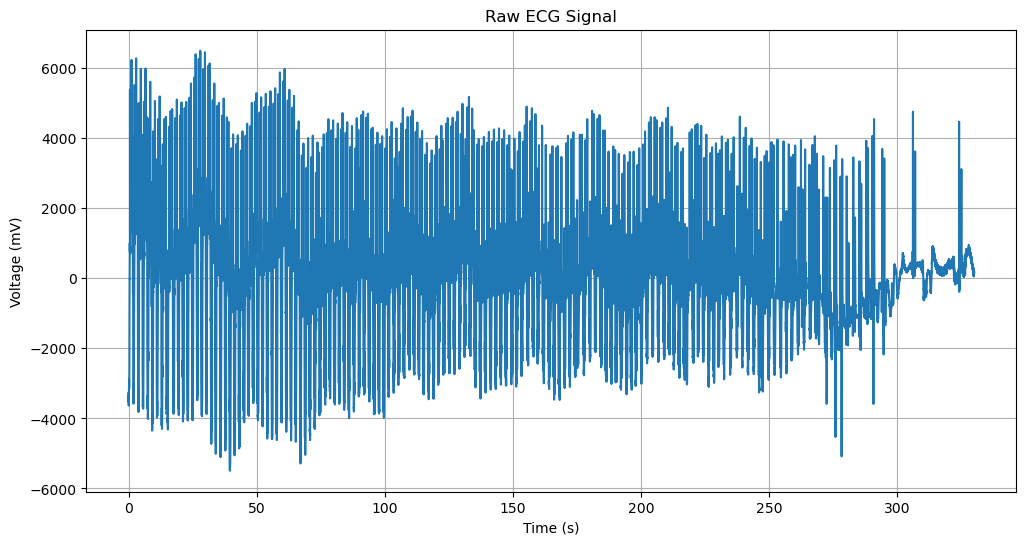

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#Declare sampling rate and time vector
sampling_rate = 250
ecg_time = np.arange(len(ecg_data))/sampling_rate

#Plot Raw ECG Data
plt.figure(figsize=(12,6))
plt.plot(ecg_time, ecg_data)
plt.title("Raw ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel ("Voltage (mV)")
plt.grid(True)
plt.show()

##### 1.3 (2 pts) Visual Inspection of the ECG Signal

Visually inspect the ECG signal. Which components or features can you identify?

There are a few components or features that can be identified from the raw ECG signal. The tall, sharp, and jagged peaks represent the QRS complexes, which is the depolarization of the heart ventricles. This is repeated throughout the signal (Sörnmo & Laguna, 2005).

Around 300 seconds, there is a sharp change in the number of QRS complexes. The signal loses most of its amplitude and becomes, for the most part, a flat line. This is indicative of asystole - the loss of electrical activity in the heart (Cleveland Clinic, 2022).

The signal also appears to have a lot of noise. Firstly, the signal appears to move around amplitude 0 (0 mV). This is known as baseline wander or drift - low frequency noise caused by patient breathing and movement (Kumar et al, 2018).  Secondly, the fuzziness nature of the graph could be due to high frequency noise, which is typically caused by powerline interference, electromyographic (EMG) noise, and electrode misplacement or shifting (Blanco-Velasco, 2007).

### 2. (10 pts) Fourier Transform:

### 2.1 (5 pts) Fourier Transform and Plotting

Find the Fourier Transform (FT) of the ECG signal by applying the Fast Fourier Transform (FFT).
(Note: Before performing the transform, make sure the signal is stored as a **1D NumPy array**.)

Plot **only the positive half of the frequency spectrum**, with:  
- Magnitude spectrum on the y-axis  
- Positive frequencies (in Hz) on the x-axis

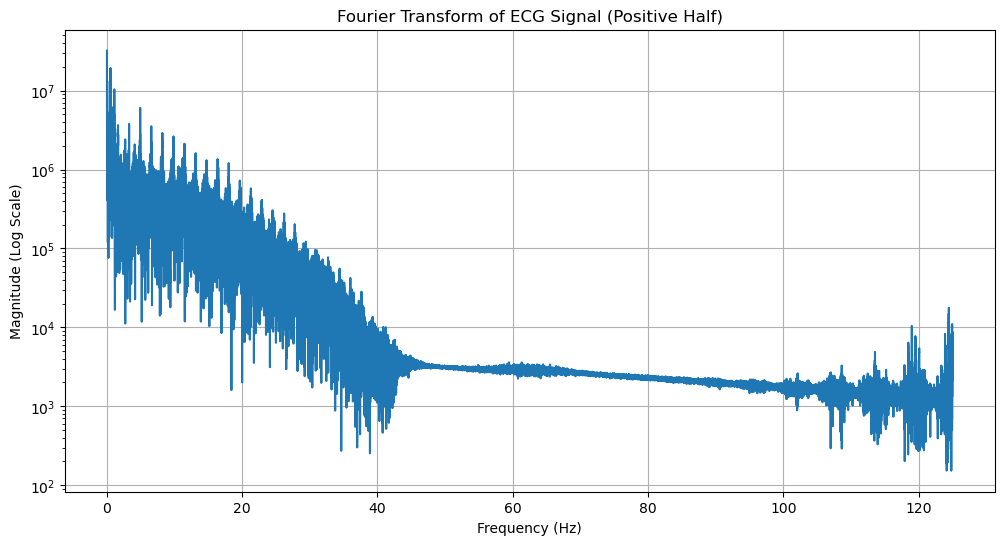

In [5]:
# Store the ECG signal as 1D NumPy array
ecg_data_1d = np.squeeze(ecg_data)

# Declare sampling parameters
sampling_rate = 250
ecg_time = np.arange(len(ecg_data))/sampling_rate

# Perform FFT
ft = np.fft.fft(ecg_data_1d)
magnitude = np.abs(ft)
freqs = np.fft.fftfreq(len(ft), d=1/sampling_rate)

# Plot the positive half of the frequency spectrum
plt.figure(figsize=(12,6))
# Only plots positive frequencies
plt.plot(freqs[:len(freqs)//2], magnitude[:len(freqs)//2])      
plt.title("Fourier Transform of ECG Signal (Positive Half)")
plt.xlabel("Frequency (Hz)")
# Logarithmic scale for better visualization
plt.yscale("log")
plt.ylabel("Magnitude (Log Scale)")
plt.grid(True)
plt.show()

##### 2.2 (5 pts) Dominant Frequencies

What are the dominant frequencies in the Fourier Transform (FT) based on your observations?  
What do these frequencies most likely correspond to? (Note: Please provide references to support your interpretation.)

There are several dominant frequencies highlighted by the Fourier transform. When plotted on a linear scale, all frequencies are dwarfed by the dominant 0 Hz frequency. This frequency corresponds to the baseline wander that we see throughout the signal - the oscillation of the signal around the baseline (0 mv) due to respiration and movement. 

Since the 0 Hz frequency dominates all other frequencies, the Fourier transform was plotted on a logarithmic scale to better visualize all other signals and noise.

There's a band of dominant frequencies that occur at approximately 1-40 Hz. This corresponds to most of the electrical activity of the heart, including the QRS complex. The P wave can be characterized by 5-30 Hz frequencies and the QRS is typically found within 8-50 Hz frequencies (Tereshchenko & Josephson, 2016).

There are other frequencies on this plot that are not the most dominant, but represent noise in the data. Around 50-70 Hz we can see a very small frequency band. This frequency is indicative of typical noise caused by powerline interference, which is often produced by the electrical powering system, but can also be caused by myoelectric contraction (Bahaz & Benzid, 2018). There is also noise above 100 Hz, which can be caused by many things, such as cable and electrode movement, but also by high frequency electrical activity in muscular tissues (Fariha Mohd Apandi et al, 2020).

### 3. (10 pts) Filtering:

##### 3.1 (5 pts) Bandpass Filtering to Remove Noise 

The signal contains noise at both high and low frequencies. Apply a bandpass filter to remove this noise, using a cutoff frequency range of 5 Hz to 50 Hz.

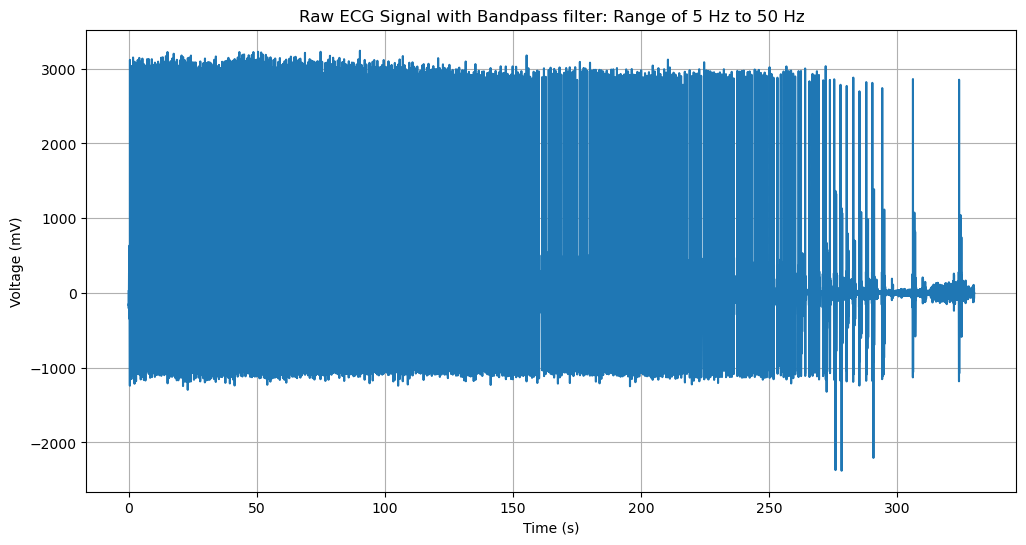

In [6]:
from scipy import signal

# Declare sampling parameters
sampling_rate = 250
ecg_time = np.arange(len(ecg_data))/sampling_rate

#  Use 4th order butterworth bandpass filter with cutoff frequencies of 5 Hz and 50 Hz
num_coeff, den_coeff = signal.butter(4, [5, 50], fs=sampling_rate, btype="band")
filtered_ecg = signal.filtfilt(num_coeff, den_coeff, ecg_data_1d)

# Plot the filtered ECG signal
plt.figure(figsize=(12,6))
plt.plot(ecg_time, filtered_ecg)
plt.title("Raw ECG Signal with Bandpass filter: Range of 5 Hz to 50 Hz")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.grid(True)
plt.show()

##### 3.2 (5 pts) Justification for Bandpass Filtering 

Why should we use a bandpass filter on this signal instead of a lowpass or highpass filter?  
What might be some sources of the noise we are trying to remove? (Note: Please provide references to support your interpretation.)

A bandpass filter is necessary for removing the low and high frequency noise found in our ECG signal. A lowpass or highpass filter on its own would be insufficient. 

A lowpass filter would only remove high frequency noise, such as the powerline interference or high frequency muscle electrical activity (>50 Hz). The low frequency noise, specifically the baseline wander seen in the signal, would remain. 

A highpass filter would do the opposite of the lowpass filter. It would remove the low frequency noise and therefore correct the baseline wander, but it would also keep the high frequency noise casued by powerline interference, muscle activity, and or cable/electrode movement. (Kher & Vidyanagar, 2019).

The bandpass filter will remove all the noise mentioned above, at both high and low frequencies. This ensures that the clinically important part of the ECG signal is kept and undistorted. The QRS, a crucial component of an ECG signal, is found in the frequency range of approximately 8-50 Hz. The cutoff frequencies chosen for our filter (5 Hz and 50 Hz) perfectly capture our key features (Fedotov, 2016).

### 4. (25 pts) Comparison:

##### 4.1 (10 pts) Comparison between Raw and Filtered Signals in the Time Domain

Identify a 5-second window where the filtered ECG differs significantly from the raw ECG in the same interval.  
Using a 2-row subplot, plot this 5-second window with the raw signal on the top and the filtered signal on the bottom. (Note: Be sure to label the plots clearly.)

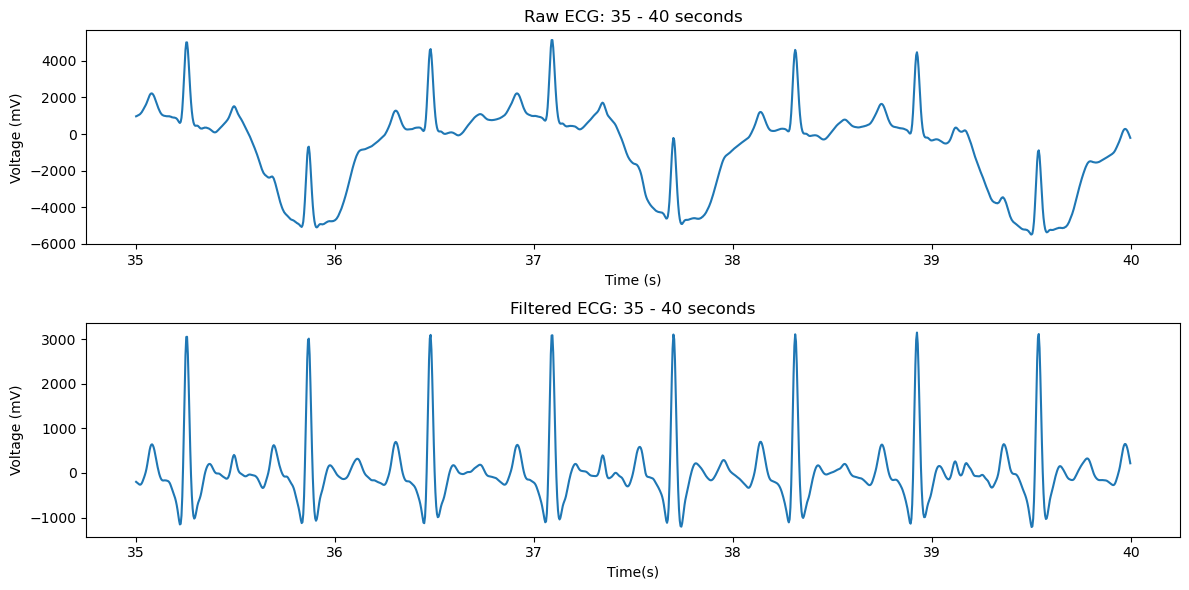

In [7]:
# --- Declare a 5 second window ---

# At ~35s, the Raw ECG signal is furthest from baseline (largest difference compared to filtered ECG)
start_time = 35             #seconds
end_time = start_time + 5   #seconds

# Convert time window (s) to sample indices
start_index = int(start_time * sampling_rate)
end_index = int(end_time * sampling_rate)

# --- Plot the raw and filtered signals ---

plt.figure(figsize=(12,6))

# Top Plot: Raw ECG Signal (35-40 seconds)
plt.subplot(2,1,1)
plt.plot(ecg_time[start_index:end_index], ecg_data_1d[start_index:end_index])
plt.title("Raw ECG: {} - {} seconds".format(start_time, end_time))
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")

# Bottom Plot: Filtered ECG Signal (35-40 seconds)
plt.subplot(2,1,2)
plt.plot(ecg_time[start_index:end_index], filtered_ecg[start_index:end_index])
plt.title("Filtered ECG: {} - {} seconds".format(start_time, end_time))
plt.xlabel("Time(s)")
plt.ylabel("Voltage (mV)")

plt.tight_layout()
plt.show()

##### 4.2 (15 pts) Comparison between Raw and Filtered Signals in the Frequency Domain

Plot the positive half of the frequency spectrum (as in Section 2.1) for the entire filtered signal and overlay it on the Fourier Transform (FT) of the raw signal.  
Describe the differences between the two signals. Which frequencies were removed by the bandpass filter, and what might they represent?

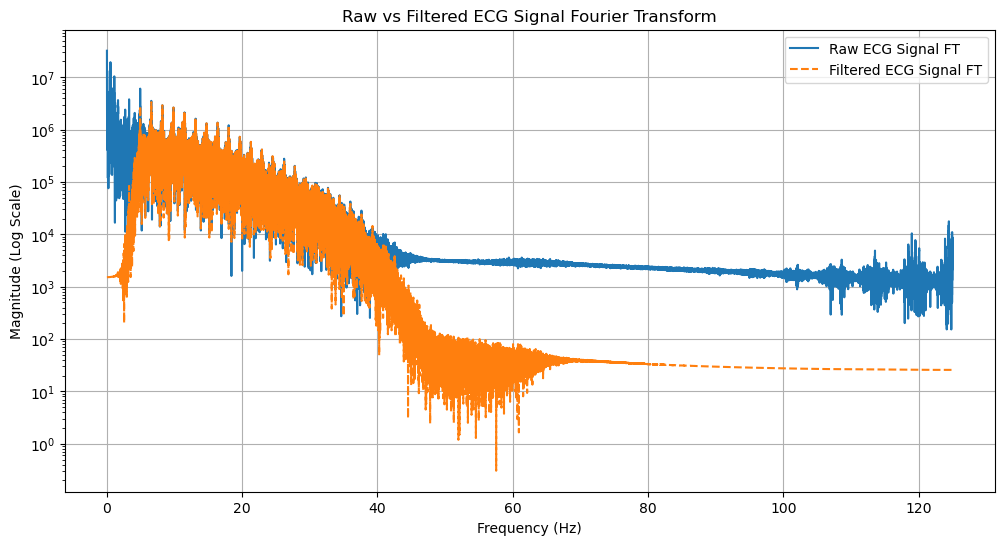

In [8]:
# Declare sampling parameters
sampling_rate = 250
ecg_time = np.arange(len(ecg_data))/sampling_rate

#  Use 4th order butterworth bandpass filter with cutoff frequencies of 5 Hz and 50 Hz
num_coeff, den_coeff = signal.butter(4, [5, 50], fs=sampling_rate, btype="band")
filtered_ecg = signal.filtfilt(num_coeff, den_coeff, ecg_data_1d)

# Perform FFT
filtered_ft = np.fft.fft(filtered_ecg)
filtered_magnitude = np.abs(filtered_ft)
filtered_freqs = np.fft.fftfreq(len(filtered_ft), d=1/sampling_rate)

# --- Plot the positive half of the raw and filtered frequency spectrum ---

plt.figure(figsize=(12,6))

# Positive half of the Raw ECG Signal FT
plt.plot(freqs[:len(freqs)//2], magnitude[:len(freqs)//2], label="Raw ECG Signal FT") 
# Positive half of the Filtered ECG Signal FT
plt.plot(filtered_freqs[:len(filtered_freqs)//2], filtered_magnitude[:len(filtered_freqs)//2], "--", label="Filtered ECG Signal FT")
plt.title("Raw vs Filtered ECG Signal Fourier Transform")
plt.xlabel("Frequency (Hz)")
plt.legend()
# Logarithmic scale for better visualization
plt.yscale("log")                                               
plt.ylabel("Magnitude (Log Scale)")
plt.grid(True)
plt.show()

There are major differences between the raw and filtered signals now. Since the raw signal fourier transform has an extreme dominant frequency at 0 Hz that dwarfs other frequencies, the raw and filtered fourier transformations are plotted above on a logarithmic scale for better visualization.

The bandpass filter was specifically designed to remove low frequency noise below 5 Hz and high frequency noise above 50 Hz. Below 5 Hz, we see that the dominant 0 Hz frequency has been drastically attenuated (reduced). This noise was predominantly caused by baseline wander, a deviation from the signal baseline due to respiration or movement (Kumar et al, 2018). Before filtering, this frequency had a magnitude of over $10^7$. After filtering, this frequency's magnitude was reduced to about $10^3$. This noise is now 10,000 times weaker in the filtered signal than it was in the raw signal. 

The filtered signal frequency band starts to match the raw signal frequency band between 5 Hz and 50 Hz, which is our desired result. This range should have our physiological data of interest. For example, the P wave typically corresponds to frequencies of 5-30 Hz, and the QRS wave corresponds to frequencies of 8-50 Hz (Tereeshchenko & Josephson, 2016). The strength of those frequencies are preserved.

Between 40 and 60 Hz we see the filtered signal begin to diminish in strength as it moves towards the high frequency cut off of 50 Hz. Above 50 Hz we see strong attenuation of the frequencies, with magnitudes that were previously around $10^3$ and $10^4$ dropping to $10^2$. This effectively removes high frequency noise that can be attributed to powerline interference and myoelectric contraction (Bahaz & Benzid, 2018). This cutoff frequency also removes the noise above 100 Hz, which can be caused by cable/electrode movement or high frequency muscle activity (Fariha Mohd Apandi et al, 2020).




## Part II - Asystole Detection in ECG

### 5. (50 pts) Asystole Detection Function

##### 5.1 (15 pts) Function Design

Write a Python function that raises an alarm when asystole is detected. Your function should:

- Take as input the **ECG signal (`ecg`)** and the **sampling rate (`Fs`)**.  
- Use a **sliding window** on the **filtered ECG signal**:  
  - Window length = **4 seconds** (minimum needed to detect asystole).  
  - Sliding interval = **1 second**.  
  - For example, check seconds 0–4, then 1–5, 2–6, and so on.  
  - The output binary array (`alarm`) should have a length of approximately **327**.  
- Select a **feature or value** for each window that can distinguish between normal ECG activity and asystole.  
- Apply a **threshold or decision rule** to determine whether the alarm should be raised in each window.  
- Return both:  
  - A binary array (`alarm`) indicating whether the alarm is raised at each step.  
  - The **time (in seconds)** of the first detected asystole, or 0 if none is detected.  
- Comment your code clearly and mute any unnecessary output using `#`.

##### 5.2 (15 pts) Implement the Function and Plot Results

Implement your `asystole_detection` function from Section 5.1 and test it on the provided ECG data.  

- Apply your function to the ECG signal and record both the **alarm array** and the **first asystole detection time (in seconds)**.  
- Plot the results using a 2-row subplot:  
  - **Top subplot:** the raw ECG signal versus time (in seconds).  
  - **Bottom subplot:** the alarm array as a step plot, with time on the x-axis (1-second hops) and the binary alarm (0 = normal, 1 = asystole) on the y-axis.  
- Add appropriate **titles, axis labels, legends, and grids** for clarity.  
- After plotting, print a message that reports the time of the first detected asystole (or indicate if none was detected).


##### 5.3 (10 pts) Why did you choose the feature or value you selected?
    
(Note: Please provide references to support your interpretation.)

##### 5.4 (10 pts) Why did you choose the specific threshold or metric for detecting asystole?

(Note: Please provide references to support your interpretation.)